## Bring up dummy endpoints and synthetic traffic

Next, we will stand up a simple application layer for GourmetGram: “dummy” API endpoints for users, uploads, comments, views, and flags, that will persist data to our PostgreSQL database (and, images to the object storage service). Then we will run a synthetic traffic generator against those endpoints.

This gives us realistic application activity in PostgreSQL before we add more advanced platform pieces.

The data flow we are setting up in this phase is illustrated in the following diagram:

<figure>
<img src="images/application-flow.png" alt="Application data flow" />
<figcaption aria-hidden="true">Application data flow</figcaption>
</figure>

At this stage:

-   `data_generator` sends HTTP requests to `api_v1` endpoints
-   `api_v1` writes application state to PostgreSQL (`users`, `images`, `comments`, `flags`)
-   `api_v1` writes uploaded image objects to MinIO

This is the baseline flow we will build on in the rest of the experiment.
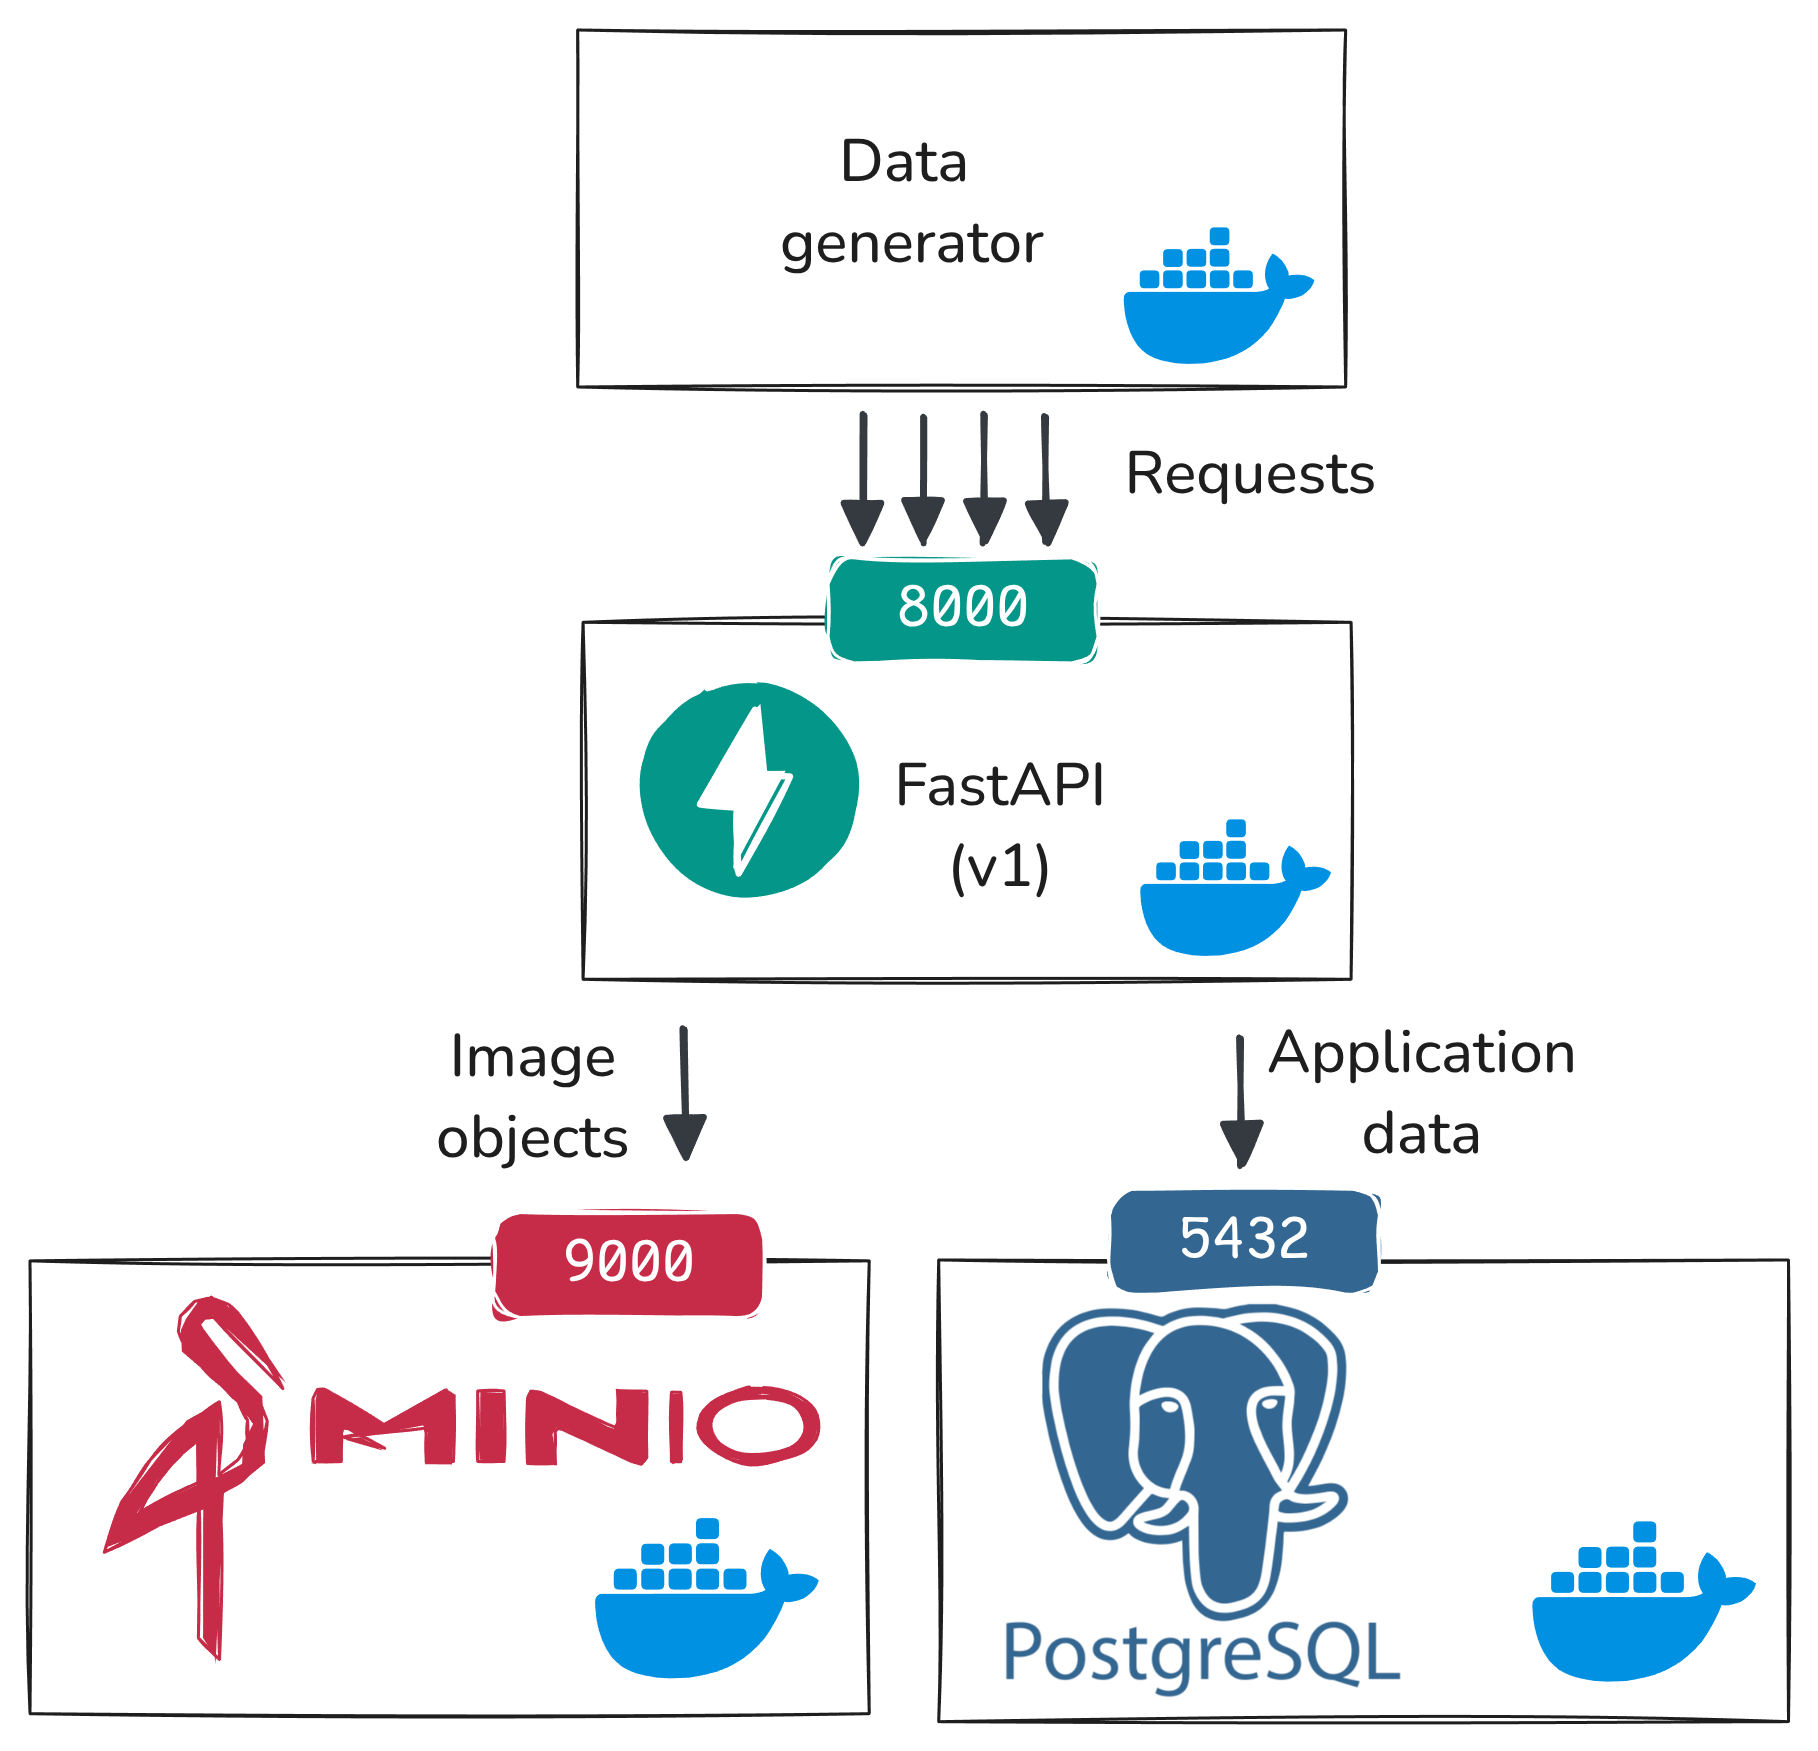

### Step 1: Prepare image data artifacts

At this point, PostgreSQL/Adminer and MinIO/buckets are already running from the previous notebook.

Now, prepare image data (the Food-11 dataset). The synthetic data generator will randomly select existing food images from this data to send to our endpoint.

The `extract-data` and `transform-data` steps download and organize the Food-11 dataset used by the generator.

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d \
  extract-data transform-data
```

### Step 2: Start dummy API endpoints

Now bring up the API service:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d api_v1
```

and use

``` bash
# run on node-data
docker ps
```

to confirm it is running.

To see how these endpoints work and what type of input they accept, open the docs in your browser (substituting your floating IP in place of `A.B.C.D`):

-   `http://A.B.C.D:8000/docs`

In the docs page:

1.  Click one endpoint row (for example `POST /upload/`).
2.  Click Try it out.
3.  Review the example request fields.
4.  Click Cancel (or do not execute) and repeat for other endpoints.

Take screenshots for later reference.

These endpoints are “dummy” in the sense that we haven’t built any application logic on top of them, but they model the core application workflow we need for the rest of the lab.

### Step 3: Start synthetic traffic generation

Now, start the synthetic data generator:

``` bash
# run on node-data
docker compose -f /home/cc/data-platform-chi/docker/docker-compose.yaml up -d data_generator
```

and once it is up, watch its logs:

``` bash
# run on node-data
docker logs -f generator
```

You should see activity like user creation, image uploads, comments, views, and flags.

Go back to Adminer (`http://A.B.C.D:5050`) and log in with:

-   System: `PostgreSQL` (use drop-down to change it)
-   Server: `postgres`
-   Username: `user`
-   Password: `gourmetgram_postgres`
-   Database: `gourmetgram`

Then, confirm that records are accumulating in the `comments`, `flags`, `images`, and `users` tables, and that in the `images` table, some images are accumulating views. (Click on a table, then “Select data” to see the data in the table.)

Take screenshots of Adminer table views for `comments`, `flags`, `images`, and `users` as well as example rows from each table.

In MinIO (`http://A.B.C.D:9001`):

1.  Click Object Browser.
2.  Click `gourmetgram-images`.
3.  Confirm uploaded files are appearing. You can click on file and then choose the “Preview” option in the sidebar to see the image.